# Time Series Prediction 

## Introduction

Welcome to the `time_series.ipynb` notebook! Building upon our in-depth exploratory data analysis, we are now venturing into the realm of time series prediction for SNCF train delays. In this notebook, we will delve into the complexities of forecasting `retard_moyen_arrive` (average arrival delays) using historical data. Through a meticulous approach, we aim to answer a series of pivotal questions that emerged during our analysis phase.

## Key Questions and Approaches

Our exploration leads us to fundamental questions that guide our time-series prediction approach:

1. **Determination of Historical Window:** How long should be the past window for accurate predictions?
   
2. **Handling Time Lag:** Given the task of predicting the next 6 months, how does the application of a time lag influence the model's performance?

3. **Complexity of Features:** Timeseries models are typically simpler on the variable to predict. How can we effectively utilize multiple features, such as `duree_moyenne`, `retard_moyen_depart`, and others, to enhance prediction accuracy?
   
4. **Incorporating Non-Historical Features:** Departure and destination locations are vital non-historical features. How can these be integrated into our time series approach for a comprehensive prediction model?
   
5. **Modeling Strategies:** Should we construct individual models for each itinerary, or opt for a unified model encompassing all itineraries?
   
6. **Dimensionality Challenges:** Utilizing 7 historic features within a one-year window results in a substantial number of input features (84 features). Should we explore techniques like PCA (Principal Component Analysis) to reduce dimensionality, or consider alternative methods to manage feature complexity?

Through rigorous modeling and analysis, we aim to address these questions and pave the way for a robust predictive model. Let's embark on this exciting journey into the realm of time series forecasting, aiming to optimize predictions for SNCF train delays and unravel patterns in the data.

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
path = "/Users/danielrodriguez/Desktop/"
data_tgv = pd.read_csv(path + "projet-ML-CS/data/preprocessed_tgv_data.csv",sep=";")

In [3]:
standard_duration = dict(zip(data_tgv["gare_depart"]+data_tgv["gare_arrivee"],data_tgv["duree_standard"]))

## 1. Tranform data for time series approach

In [4]:
# Let's build the features from the data
# - duree_moyenne/duree_standard
# - retard_moyen_depart/duree_standard
# - retard_moyen_arrivee/duree_standard
# - retard_moyen_tous_trains_arrivee/duree_standard
# - retard_moyen_trains_retard_sup15/duree_standard
# - nb_train_retard_sup_30/nb_train_prevu
# - nb_train_retard_sup_60/nb_train_prevu

data_tgv["duree_moyenne_norm"] = data_tgv["duree_moyenne"] / data_tgv["duree_standard"]
data_tgv["retard_moyen_depart_norm"] = data_tgv["retard_moyen_depart"] / data_tgv["duree_standard"]
data_tgv["retard_moyen_arrivee_norm"] = data_tgv["retard_moyen_arrivee"] / data_tgv["duree_standard"]
data_tgv["retard_moyen_tous_trains_arrivee_norm"] = data_tgv["retard_moyen_tous_trains_arrivee"] / data_tgv["duree_standard"]
data_tgv["retard_moyen_trains_retard_sup15_norm"] = data_tgv["retard_moyen_trains_retard_sup15"] / data_tgv["duree_standard"]
data_tgv["nb_train_retard_sup_30_norm"] = data_tgv["nb_train_retard_sup_30"] / data_tgv["nb_train_prevu"]
data_tgv["nb_train_retard_sup_60_norm"] = data_tgv["nb_train_retard_sup_60"] / data_tgv["nb_train_prevu"]

features_list = [
    "date",
    "gare_depart",
    "gare_arrivee",
    "duree_moyenne_norm",
    "retard_moyen_depart_norm",
    "retard_moyen_arrivee_norm",
    "retard_moyen_tous_trains_arrivee_norm",
    "retard_moyen_trains_retard_sup15_norm",
    "nb_train_retard_sup_30_norm",
    "nb_train_retard_sup_60_norm",
]
features_list_2 = [
    "date",
    "gare_depart",
    "gare_arrivee",
    "retard_moyen_arrivee",
    "duree_moyenne"
]

In [5]:
def sliding_window(elements, window_size):
    """
    This function takes a list of elements and a window size and returns a list of lists of elements
    """
    matrix = []
    if len(elements) <= window_size:
       raise ValueError("The window size is bigger than the number of elements")
    for i in range(len(elements)- window_size + 1):
        matrix+=[elements[i:i+window_size]]
    
    return matrix


In [6]:

def TimeSeriesTransformer(
          X: pd.DataFrame, 
          window:int = 12, 
          lag:int = 6, 
          groupby_dimensions: list = ["gare_depart","gare_arrivee"], 
          target_dimension:str = "retard_moyen_arrivee_norm"
):
        
        features_to_transform = list(X.columns)
        features_to_transform.remove("date")
        for dim in groupby_dimensions:
            features_to_transform.remove(dim)
        final_list_features = ["date"] + groupby_dimensions
        
        X.sort_values(by=["date"],inplace=True)


        list_X = []
        total_window = window + lag + 1
        

        for val,group in X.groupby(groupby_dimensions):
            concat_df_list = []
            for dimension in features_to_transform:
                df = pd.DataFrame(
                        sliding_window(group[dimension].tolist(),total_window),
                        columns=["M"+str(i)+"_"+dimension for i in range(-total_window+1,0,1)] + ["M_"+dimension]
                    )
                for i in range(-lag,0,1):
                    df.drop(columns=["M"+str(i)+"_"+dimension],inplace=True)

                if not(dimension == target_dimension):
                    df.drop(columns=["M_"+dimension],inplace=True)

                concat_df_list += [df.copy()]

            df_for_group = pd.concat(concat_df_list, axis=1)
            df_for_group["date"]=group["date"].values[total_window-1:]
            for i,feature in enumerate(groupby_dimensions):
                df_for_group[feature]=val[i]
            list_X+=[df_for_group.copy()]

        final_list_features += ["M"+str(i)+"_"+dime for i in range(-total_window+1,-lag,1) for dime in features_to_transform]+["M_"+target_dimension]

        final_df = pd.concat(list_X,axis=0,ignore_index = True)
        return final_df[final_list_features].copy()



In [7]:
data = TimeSeriesTransformer(data_tgv[features_list].copy())

In [46]:
display(data.head())

,date,gare_depart,gare_arrivee,M-18_duree_moyenne_norm,M-18_retard_moyen_depart_norm,M-18_retard_moyen_arrivee_norm,M-18_retard_moyen_tous_trains_arrivee_norm,M-18_retard_moyen_trains_retard_sup15_norm,M-18_nb_train_retard_sup_30_norm,M-18_nb_train_retard_sup_60_norm,...,M-8_nb_train_retard_sup_30_norm,M-8_nb_train_retard_sup_60_norm,M-7_duree_moyenne_norm,M-7_retard_moyen_depart_norm,M-7_retard_moyen_arrivee_norm,M-7_retard_moyen_tous_trains_arrivee_norm,M-7_retard_moyen_trains_retard_sup15_norm,M-7_nb_train_retard_sup_30_norm,M-7_nb_train_retard_sup_60_norm,M_retard_moyen_arrivee_norm
0,2019-07,AIX EN PROVENCE TGV,PARIS LYON,1.032967,0.036405,0.197661,0.024270,0.024270,0.047264,0.017413,...,0.061381,0.025575,1.027473,0.040610,0.221265,0.024820,0.024820,0.044156,0.005195,0.193610
1,2019-08,AIX EN PROVENCE TGV,PARIS LYON,1.032967,0.040068,0.185911,0.031059,0.031059,0.050562,0.008427,...,0.044156,0.005195,1.032967,0.053216,0.240891,0.039573,0.039573,0.076336,0.027990,0.167695
2,2019-09,AIX EN PROVENCE TGV,PARIS LYON,1.032967,0.043162,0.178219,0.023561,0.023561,0.035354,0.007576,...,0.076336,0.027990,1.032967,0.074019,0.424867,0.055724,0.055724,0.080332,0.049861,0.173060
3,2019-10,AIX EN PROVENCE TGV,PARIS LYON,1.032967,0.048391,0.213148,0.020526,0.020526,0.031401,0.009662,...,0.080332,0.049861,1.032967,0.045689,0.205460,0.019724,0.019724,0.033163,0.007653,0.182056
4,2019-11,AIX EN PROVENCE TGV,PARIS LYON,1.032967,0.135720,0.203663,0.030155,0.030155,0.056098,0.019512,...,0.033163,0.007653,1.010989,0.036236,0.242033,0.018122,0.018122,0.029491,0.016086,0.259774


## 2. Determine the lenght of the historical window using linear regressions and study lags influence

We are going to study the R-squared on the test and training set for different lenghts of historical windows using a lag of 6 months

In [48]:
dataframes = []
for window in tqdm.tqdm(range(3,24)):
    df = TimeSeriesTransformer(data_tgv[features_list].copy(),window=window,target_dimension="retard_moyen_arrivee_norm")
    train_df = df[df["date"]< "2022-12-30"].copy()
    test_df = df[df["date"]>= "2022-12-30"].copy()
    dataframes += [
        {
            "window":window,
            "train_df":train_df,
            "test_df":test_df
        }
    ]

100%|██████████| 21/21 [01:48<00:00,  5.15s/it]


In [49]:


def get_errors(dataframes,metric="window",target="M_retard_moyen_arrivee_norm"):
    errors_list = []
    for dict_data in tqdm.tqdm(dataframes) :
        reg = LinearRegression()
        X_train = dict_data["train_df"].drop(["date","gare_depart","gare_arrivee"]+[target],axis=1)
        X_test = dict_data["test_df"].drop(["date","gare_depart","gare_arrivee"]+[target],axis=1)

        y_train = dict_data["train_df"][target].copy()
        y_test = dict_data["test_df"][target].copy()
        reg.fit(X_train,y_train)


        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)
        if "norm" in target: 
            std_duration_train = (dict_data["train_df"]["gare_depart"]+dict_data["train_df"]["gare_arrivee"]).map(standard_duration)
            std_duration_test = (dict_data["test_df"]["gare_depart"]+dict_data["test_df"]["gare_arrivee"]).map(standard_duration)
            y_pred_train = y_pred_train * std_duration_train
            y_pred_test = y_pred_test * std_duration_test
            y_train = y_train * std_duration_train
            y_test = y_test * std_duration_test

        errors_list += [
            {
                metric:dict_data[metric],
                "R2_test":r2_score(y_test,y_pred_test),
                "R2_train":r2_score(y_train,y_pred_train),
                "MAE_test":mean_absolute_error(y_test,y_pred_test),
                "MAE_train":mean_absolute_error(y_train,y_pred_train),
                "MSE_test":mean_squared_error(y_test,y_pred_test),
                "MSE_train":mean_squared_error(y_train,y_pred_train),
            }
        ]
    return pd.DataFrame(errors_list)



In [50]:
errors_df = get_errors(dataframes,target="M_retard_moyen_arrivee_norm")

100%|██████████| 21/21 [00:02<00:00,  9.94it/s]


In [12]:
def plot_errors(errors_df,metric):
    couple_errors = [
        ["R2_test","R2_train"],
        ["MAE_test","MAE_train"],	
        ["MSE_test","MSE_train"],
    ]
    for couple in couple_errors:
        plt.figure(figsize=(15, 6))
        plt.plot(errors_df[metric], errors_df[couple[0]], marker='.', color='b', linestyle='-', label=couple[0])
        plt.plot(errors_df[metric], errors_df[couple[1]], marker='.', color='r', linestyle='-', label=couple[1])
        plt.title(couple[0].split("_")[0]+' vs '+metric)
        plt.xlabel(metric)
        plt.ylabel(couple[0].split("_")[0])
        plt.legend() 
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [52]:
errors_df

,window,R2_test,R2_train,MAE_test,MAE_train,MSE_test,MSE_train
0,3,0.047481,0.168960,10.404222,9.105848,339.952440,182.993060
1,4,0.046806,0.186235,10.487972,8.990252,340.193268,179.163771
2,5,0.056442,0.203452,10.336528,8.910618,336.754538,176.049165
3,6,0.095523,0.219783,10.052122,8.829492,322.806374,173.620812
4,7,0.093890,0.234277,10.032783,8.732783,323.389064,171.719935
5,8,0.122918,0.252723,9.658235,8.372520,313.029074,159.132076
6,9,0.141922,0.262069,9.465812,8.284605,306.246802,157.328307
7,10,0.149699,0.265775,9.327937,8.268951,303.471016,158.107643
8,11,0.150695,0.269327,9.369601,8.262360,303.115689,158.019268
9,12,0.145835,0.279278,9.474156,8.162334,304.849998,155.286495


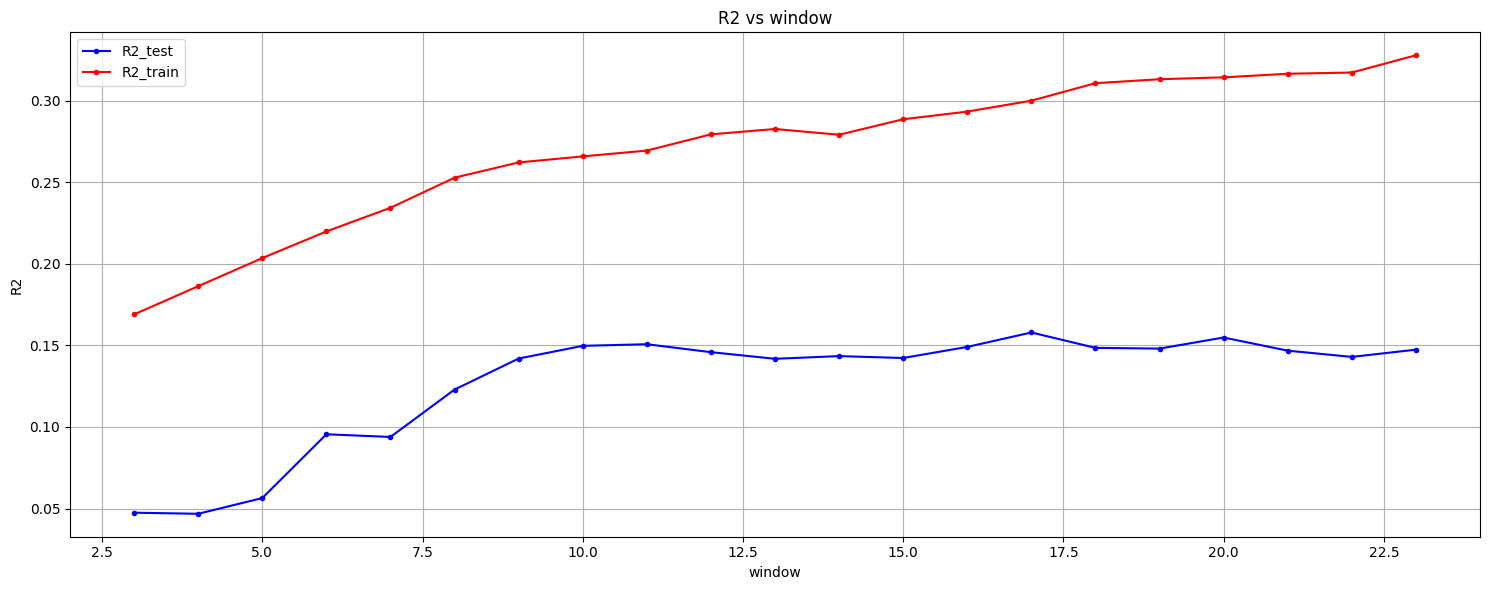

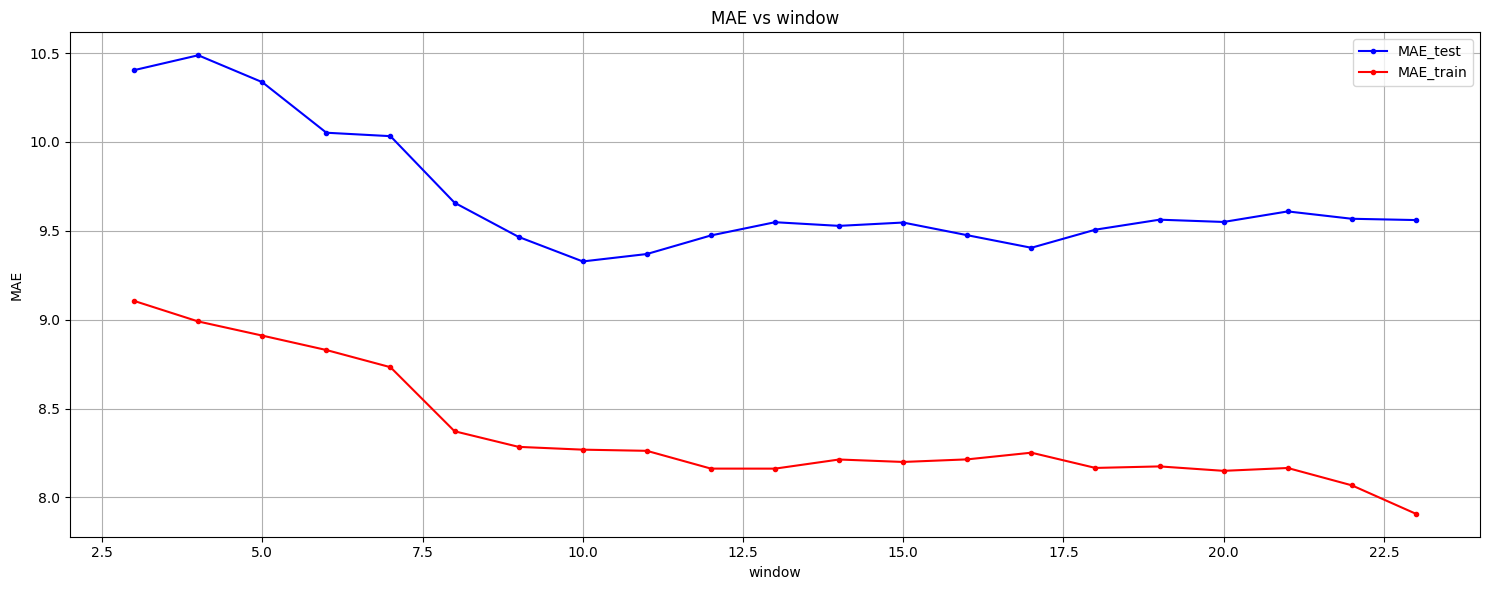

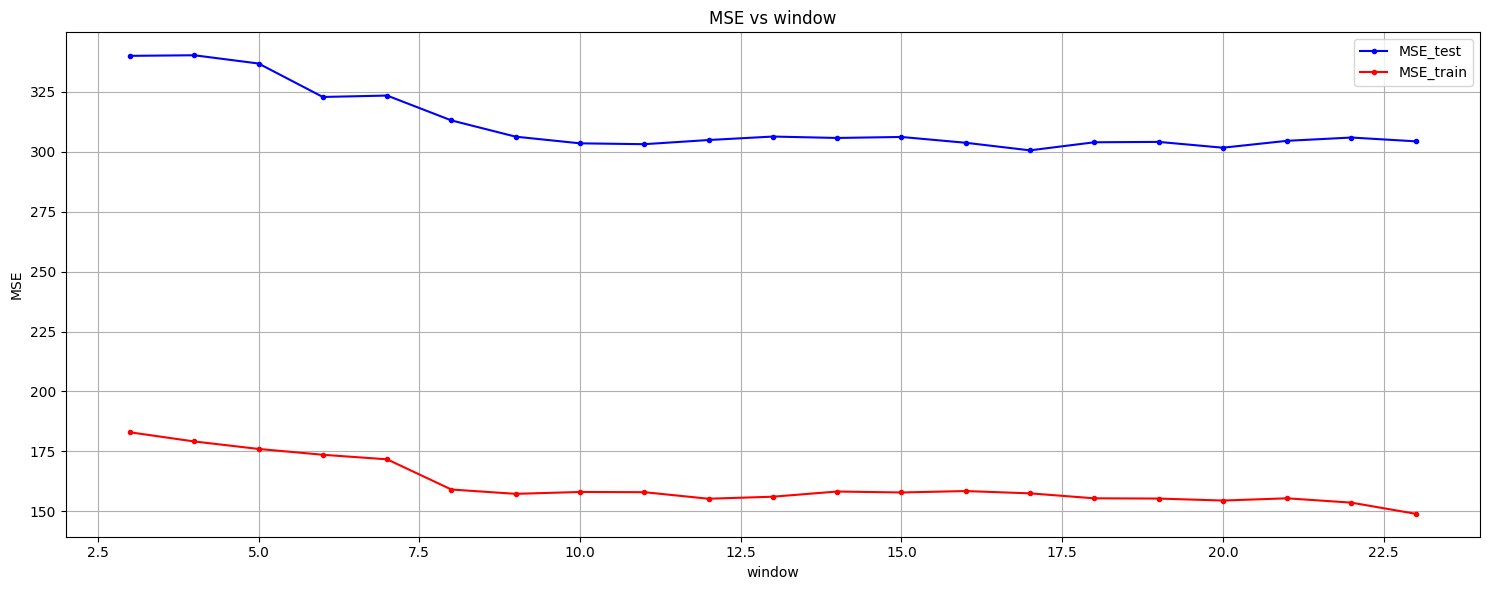

In [51]:
plot_errors(errors_df,"window")

**Observations :**

As expected, we can see that the bigger the window, the better performance on the training set (red curves).
But against all expectations we can see that after 10, the errors don't get better on the test set. So if we keep a lag of 6 months, no need to have a bigger window than 10 months.

Let's take a look of the influence of the lag:

In [15]:
dataframes_lag = []
for lag in tqdm.tqdm(range(1,12)):
    df = TimeSeriesTransformer(data_tgv[features_list].copy(),window=10,lag=lag)
    train_df = df[df["date"]< "2023-01-01"].copy()
    test_df = df[df["date"]>= "2023-01-01"].copy()
    dataframes_lag += [
        {
            "lag":lag,
            "train_df":train_df,
            "test_df":test_df
        }
    ]

100%|██████████| 11/11 [01:11<00:00,  6.53s/it]


In [16]:
errors_df = get_errors(dataframes_lag,metric="lag")

100%|██████████| 11/11 [00:01<00:00,  7.91it/s]


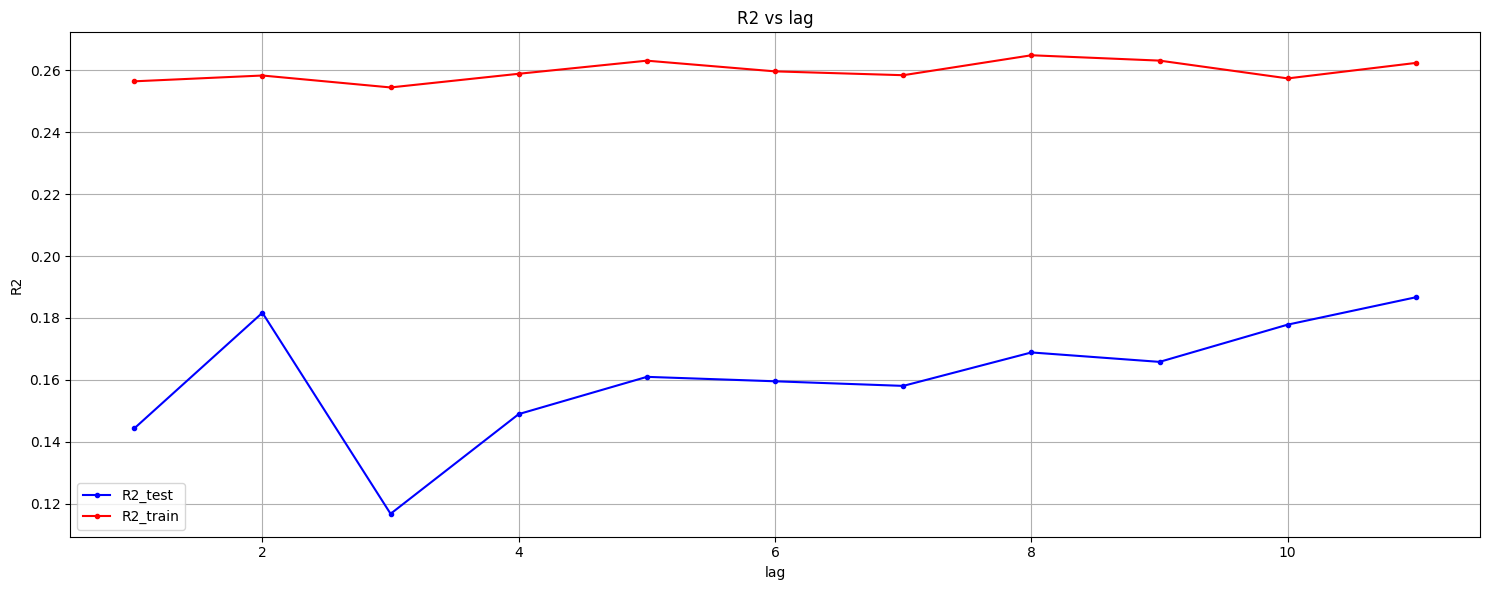

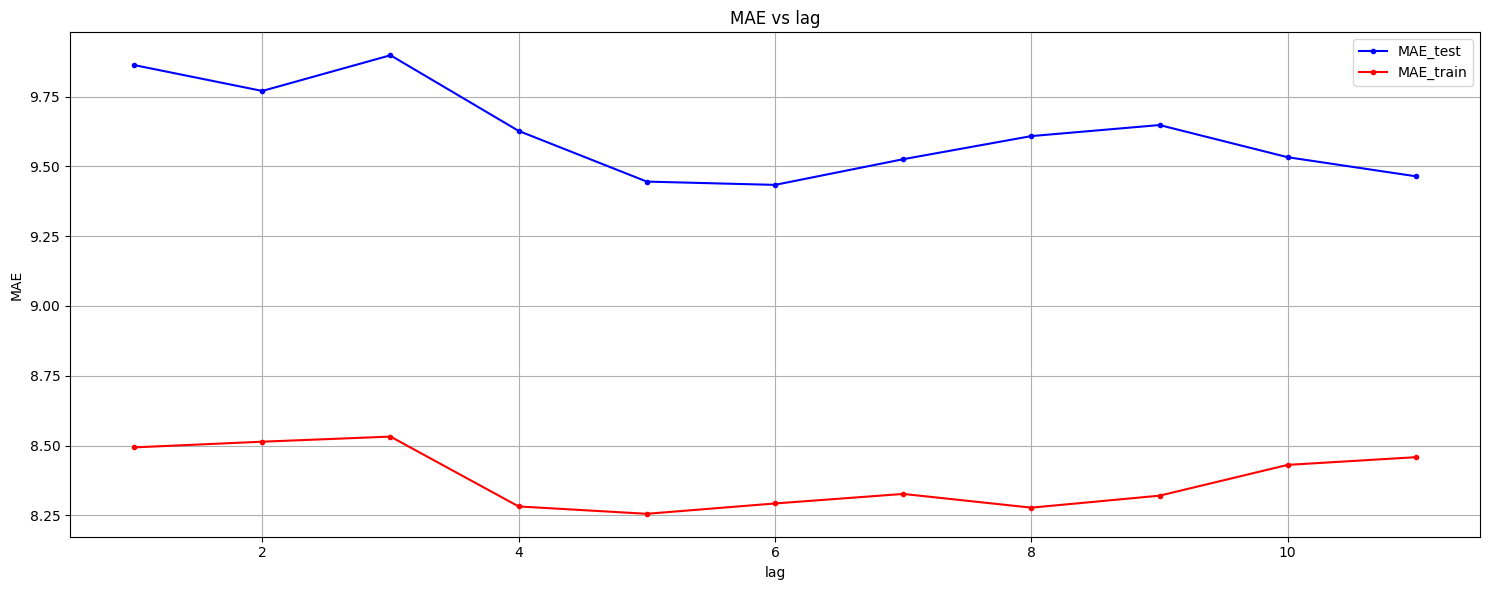

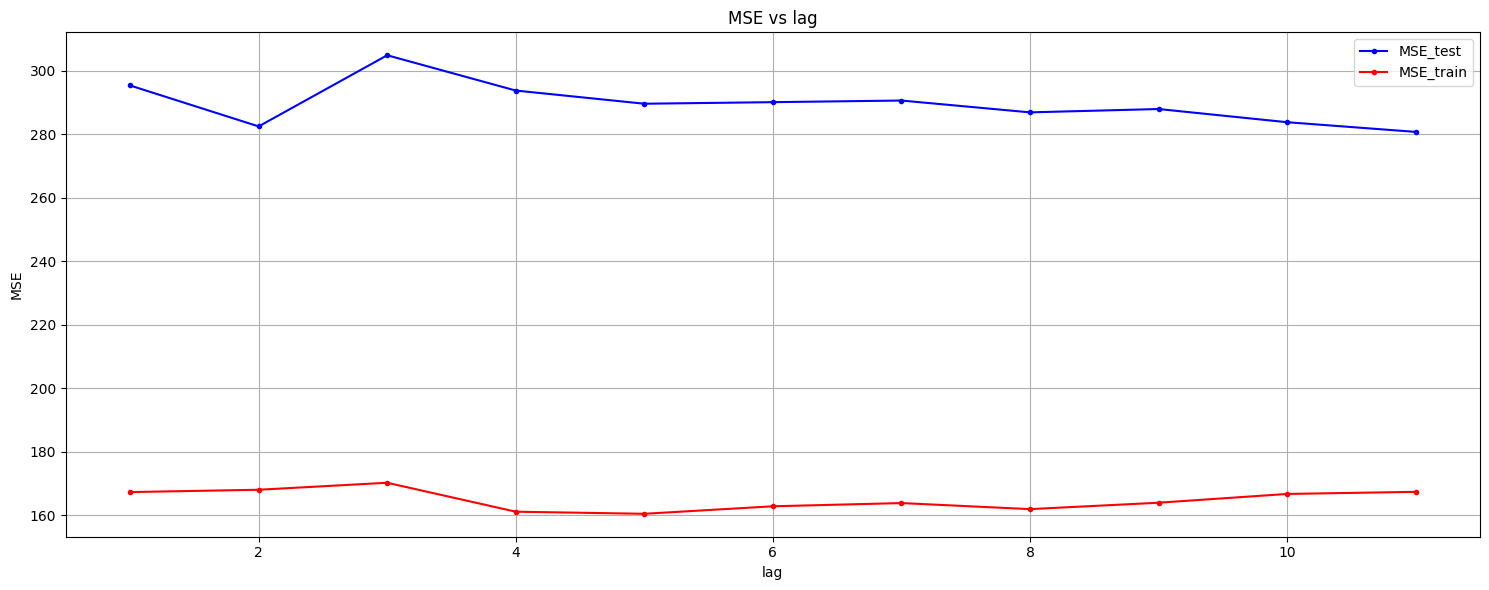

In [17]:
plot_errors(errors_df,"lag")

**Observations :**

To study lag, we fixed a window of 18 months to don't influence the error by the window lenght.

As we can on the plots, lags have almost not influence, so we will fix a lag of 6-months in order to predict the 6 months of 2023.

## 3. Test historical approach with all itineraries on the same dataset

In order to evaluate the different models we are going to focus on the mean absolute error. We do this because what we really want to know is by how many minutes our prediction is wrong in average.

To visualize the errors we are always going to plot the absolute error of a prediction against the standard duration. The reason why we do this is because an absolute error of 10 min on a trip of 3h is not the same than a error of 10 minutes on a trip of 50 minutes.

In [74]:
def split_data(data_tgv,features_list,target):
    data = TimeSeriesTransformer(data_tgv[features_list].copy(),window=10,lag=6,target_dimension=target)
    data["date"]=pd.to_datetime(data["date"])
    train_df = data[data["date"]< "2022-12-30"].copy()
    test_df = data[data["date"]>= "2022-12-30"].copy()
    X_train = train_df.drop(columns=["date", "gare_depart", "gare_arrivee", "M_"+target])
    y_train = train_df["M_"+target]
    X_test = test_df.drop(columns=["date", "gare_depart", "gare_arrivee", "M_"+target])
    y_test = test_df["M_"+target]
    std_duration_train = (train_df["gare_depart"]+train_df["gare_arrivee"]).map(standard_duration)
    std_duration_test = (test_df["gare_depart"]+test_df["gare_arrivee"]).map(standard_duration)
    return train_df,test_df,X_train,X_test,y_train,y_test,std_duration_train,std_duration_test

train_df,test_df,X_train,X_test,y_train,y_test,std_duration_train,std_duration_test = split_data(data_tgv,features_list,"retard_moyen_arrivee_norm")

### Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

linear_regressor = LinearRegression()
linear_regressor.fit(X_train,y_train)

y_pred_train = linear_regressor.predict(X_train)
y_pred_test = linear_regressor.predict(X_test)

y_pred_train = y_pred_train * std_duration_train
y_pred_test = y_pred_test * std_duration_test
y_train_ = y_train * std_duration_train
y_test_ = y_test * std_duration_test

print("########### TEST ###########")
print("R-squared :", r2_score(y_test_,y_pred_test))
print("MSE :", mean_squared_error(y_test_,y_pred_test))
print("MAE :", mean_absolute_error(y_test_,y_pred_test))

print("########### TRAIN ###########")
print("R-squared :", r2_score(y_train_,y_pred_train))
print("MSE :", mean_squared_error(y_train_,y_pred_train))
print("MAE :", mean_absolute_error(y_train_,y_pred_train))


########### TEST ###########
R-squared : 0.1496991902829352
MSE : 303.4710161158432
MAE : 9.327936608784535
########### TRAIN ###########
R-squared : 0.2657749871603524
MSE : 158.1076428485651
MAE : 8.26895145860835


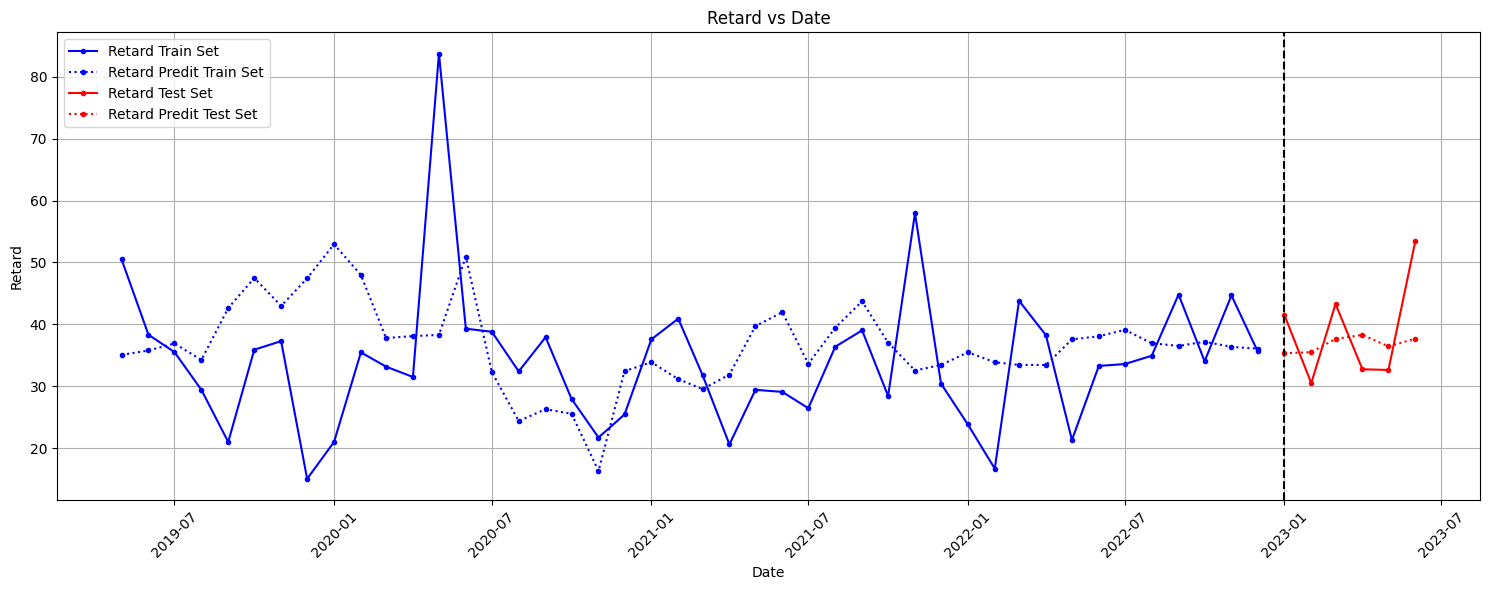

In [76]:
def visualize_itinerary(
    gare_depart,
    gare_arrive,
    train_df,
    test_df,
    y_train,
    y_pred_train,
    y_test,
    y_pred_test):

    v_data_test = test_df.copy()
    v_data_test["retard_moyen_arrivee"] = list(y_test)
    v_data_test["retard_moyen_arrivee_predit"] = list(y_pred_test)

    v_data_train = train_df.copy()
    v_data_train["retard_moyen_arrivee"] = list(y_train)
    v_data_train["retard_moyen_arrivee_predit"] = list(y_pred_train)



    v_data_train = v_data_train[(v_data_train["gare_depart"]==gare_depart)*(v_data_train["gare_arrivee"]==gare_arrive)].copy()
    v_data_test = v_data_test[(v_data_test["gare_depart"]==gare_depart)*(v_data_test["gare_arrivee"]==gare_arrive)].copy()

    plt.figure(figsize=(15, 6))
    plt.plot(v_data_train['date'], v_data_train["retard_moyen_arrivee"], marker='.', color='b', linestyle='-', label='Retard Train Set')
    plt.plot(v_data_train['date'], v_data_train["retard_moyen_arrivee_predit"], marker='.', color='b', linestyle=':', label='Retard Predit Train Set')
    plt.plot(v_data_test['date'], v_data_test["retard_moyen_arrivee"], marker='.', color='r', linestyle='-', label='Retard Test Set')
    plt.plot(v_data_test['date'], v_data_test["retard_moyen_arrivee_predit"], marker='.', color='r', linestyle=':', label='Retard Predit Test Set')
    plt.axvline(pd.to_datetime('2023-01-01'), color='black', ls='--')
    plt.title('Retard vs Date')
    plt.xlabel('Date')
    plt.ylabel('Retard')
    plt.legend()  
    plt.grid(True)
    plt.xticks(rotation=45) 
    plt.tight_layout()
    plt.show()

visualize_itinerary("GRENOBLE","PARIS LYON",train_df,test_df,y_train_,y_pred_train,y_test_,y_pred_test)

The approach of putting all the itineraries together and build a single regressor doesn't work very good. We can see the model acts like a smoothing filter, like a rolling mean of the past.

Let's try another approach, we can build clusters on the itineraries and try to build a regressor per cluster.

## 4. Clustering approach

First let's build a vector for each itinerary containing all the `retard_moyen_arrive` between 2018 and 2022

In [56]:
data = data_tgv[pd.to_datetime(data_tgv["date"]) < pd.to_datetime("2022-12-30")].copy()
data.sort_values("date",inplace=True)
data["retard_moyen_arrivee_norm"] = data["retard_moyen_arrivee"]/data["duree_standard"]
data_to_cluster = data.groupby(["gare_depart","gare_arrivee"],as_index=False).agg(
    v_retard = ("retard_moyen_arrivee_norm",list)
)

In [57]:
data_to_cluster.head()

,gare_depart,gare_arrivee,v_retard
0,AIX EN PROVENCE TGV,PARIS LYON,"[0.19766112263736263, 0.18591117214285713, 0.1..."
1,ANGERS SAINT LAUD,PARIS MONTPARNASSE,"[0.26971380466666667, 0.3974326598888889, 0.22..."
2,ANGOULEME,PARIS MONTPARNASSE,"[0.17375585483606557, 0.3444973481147541, 0.20..."
3,ANNECY,PARIS LYON,"[0.17085345243119265, 0.11742573174311927, 0.1..."
4,ARRAS,PARIS NORD,"[0.4837126358695652, 0.3425355282608696, 0.395..."


In [58]:
X_clusters = np.vstack(data_to_cluster["v_retard"].values)

Let's visualize our data using PCA

### PCA

In [59]:
scaler = StandardScaler()
pca = PCA(n_components=20)

X_clusters_scaled = scaler.fit_transform(X_clusters)
X_clusters_pca = pca.fit_transform(X_clusters_scaled)


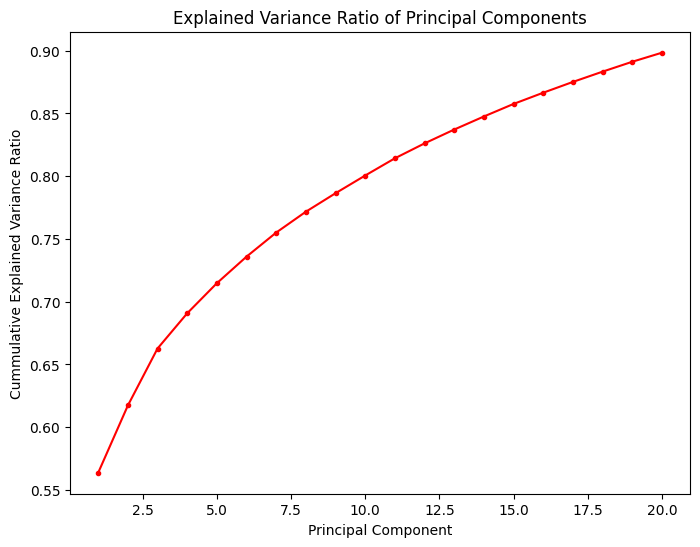

In [60]:
# Calculate the explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_var_ratio) + 1), np.cumsum(explained_var_ratio),marker='.', color='r', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Cummulative Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

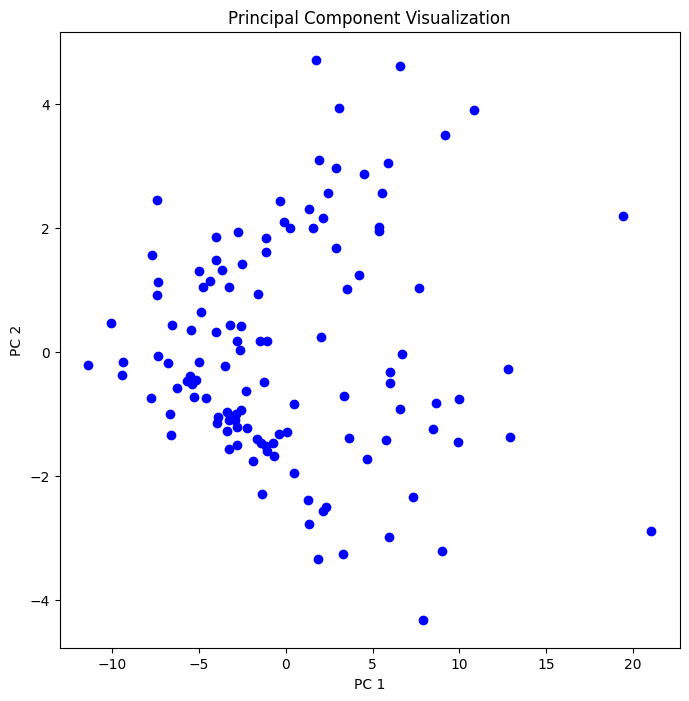

In [62]:
# Plot the explained variance ratio
plt.figure(figsize=(8, 8))
plt.plot(X_clusters_pca[:,0], X_clusters_pca[:,1],marker='o', color='b', linestyle='None')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Principal Component Visualization')
plt.show()

There is no obvious visual clustering so let's find the best k using elbow method.

### K-means

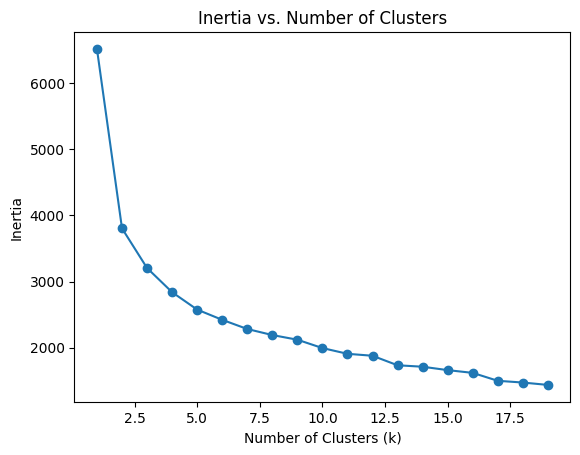

In [63]:
inertia_values = []
possible_k_values = range(1, 20) 

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10,random_state=42)
    kmeans.fit(X_clusters_pca)  
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values
plt.plot(possible_k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')
plt.show()

The clustering approach is inconclusive, there isn't a k nb of clusters that minimize the inertia.

We are going to fix k  and try to train a Linear Regression on one of this clusters to see if the performance is better.

In [64]:
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=10,random_state=42)
kmeans.fit(X_clusters_pca)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

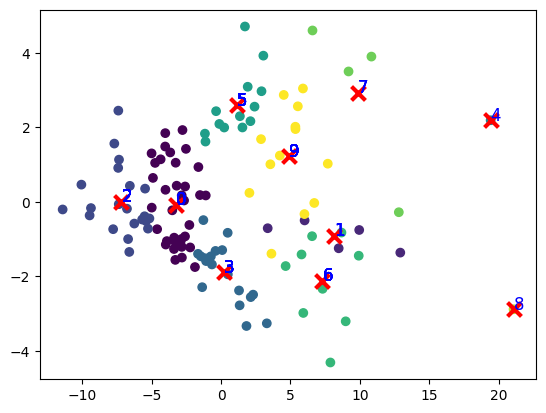

In [65]:
plt.scatter(X_clusters_pca[:, 0], X_clusters_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, linewidths=3, color='r')
for i, label in enumerate(kmeans.labels_):
    plt.text(cluster_centers[label, 0], cluster_centers[label, 1], str(label), fontsize=12, color='b')

plt.show()

In [84]:
itineraries_0 = data_to_cluster[labels==0][["gare_depart","gare_arrivee"]]
list_itineraries_0 = (itineraries_0["gare_depart"] + itineraries_0["gare_arrivee"]).tolist()
display(itineraries_0.head(10))

,gare_depart,gare_arrivee
11,BREST,PARIS MONTPARNASSE
12,CHAMBERY CHALLES LES EAUX,PARIS LYON
15,DUNKERQUE,PARIS NORD
18,GRENOBLE,PARIS LYON
20,LA ROCHELLE VILLE,PARIS MONTPARNASSE
21,LAUSANNE,PARIS LYON
25,LILLE,LYON PART DIEU
28,LYON PART DIEU,LILLE
33,LYON PART DIEU,RENNES
36,MARNE LA VALLEE,MARSEILLE ST CHARLES


### Linear Regression on a given cluster

In [85]:
filtered_data_cluster_0 = data_tgv[(data_tgv["gare_depart"] + data_tgv["gare_arrivee"]).isin(list_itineraries_0)].copy()
filtered_data_cluster_0.head(5)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,duree_standard,duree_moyenne_norm,retard_moyen_depart_norm,retard_moyen_arrivee_norm,retard_moyen_tous_trains_arrivee_norm,retard_moyen_trains_retard_sup15_norm,nb_train_retard_sup_30_norm,nb_train_retard_sup_60_norm
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165.0,222.0,0.0,8.0,2.875000,0.095796,...,3.846154,0.000000,167.0,0.988024,0.017216,0.128886,0.034108,0.034108,0.022523,0.000000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220.0,248.0,1.0,37.0,9.501351,1.003981,...,0.000000,0.000000,219.0,1.004566,0.043385,0.254303,0.034607,0.034468,0.068548,0.028226
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156.0,102.0,0.0,12.0,19.912500,1.966667,...,7.692308,0.000000,154.0,1.012987,0.129302,0.315734,0.044095,0.043667,0.058824,0.039216
5,2018-01,National,QUIMPER,PARIS MONTPARNASSE,223.0,256.0,1.0,9.0,16.333333,0.579477,...,5.555556,5.555556,222.0,1.004505,0.073574,0.176105,0.026761,0.026656,0.035156,0.007812
6,2018-01,National,RENNES,LYON PART DIEU,233.0,99.0,0.0,23.0,3.000000,0.696970,...,0.000000,0.000000,229.0,1.017467,0.013100,0.174927,0.009802,0.009802,0.020202,0.010101


In [86]:
train_df,test_df,X_train,X_test,y_train,y_test,std_duration_train,std_duration_test = split_data(filtered_data_cluster_0,features_list,"retard_moyen_arrivee_norm")

In [87]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train,y_train)

y_pred_train = linear_regressor.predict(X_train)
y_pred_test = linear_regressor.predict(X_test)

y_pred_train = y_pred_train * std_duration_train
y_pred_test = y_pred_test * std_duration_test
y_test_ = y_test* std_duration_test
y_train_ = y_train * std_duration_train

print("########### TEST ###########")
print("R-squared :", r2_score(y_test_,y_pred_test))
print("MSE :", mean_squared_error(y_test_,y_pred_test))
print("MAE :", mean_absolute_error(y_test_,y_pred_test))

print("########### TRAIN ###########")
print("R-squared :", r2_score(y_train_,y_pred_train))
print("MSE :", mean_squared_error(y_train_,y_pred_train))
print("MAE :", mean_absolute_error(y_train_,y_pred_train))


########### TEST ###########
R-squared : 0.08334425587317928
MSE : 194.34116397652565
MAE : 9.730892693971157
########### TRAIN ###########
R-squared : 0.22422698049321566
MSE : 157.85146163597915
MAE : 8.376244531119081


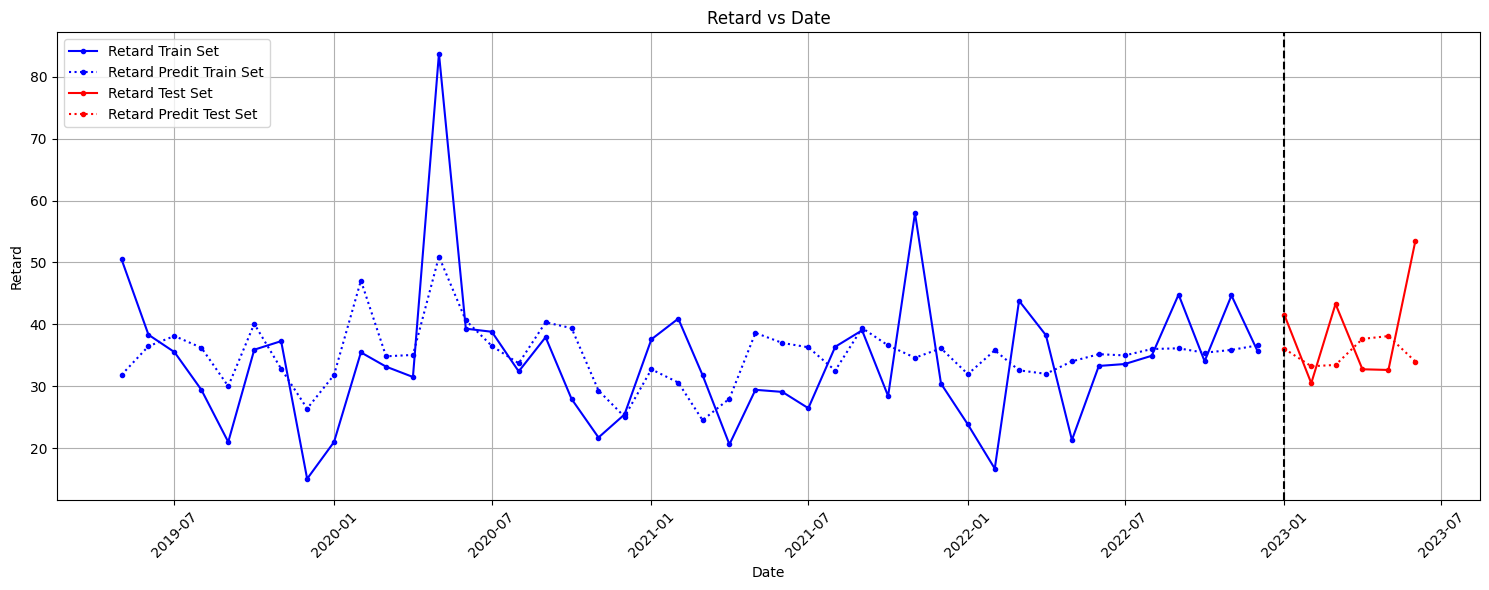

In [71]:
visualize_itinerary("GRENOBLE","PARIS LYON",train_df,test_df,y_train_,y_pred_train,y_test_,y_pred_test)

The linear regression doesn't perform any better by reducing the dataset to a given cluster. Another approach would be to try to fit a linear regression on a single intinerary to see if it performs better.

### Linear regression on a single itinerary

In [72]:
filtered_data_itinerary= data_tgv[(data_tgv["gare_depart"] == "GRENOBLE" )* (data_tgv["gare_arrivee"]=="PARIS LYON")].copy()
train_df,test_df,X_train,X_test,y_train,y_test,std_duration_train,std_duration_test = split_data(filtered_data_itinerary,features_list,"retard_moyen_arrivee_norm")

In [73]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train,y_train)

y_pred_train = linear_regressor.predict(X_train)
y_pred_test = linear_regressor.predict(X_test)

y_pred_train = y_pred_train * std_duration_train
y_pred_test = y_pred_test * std_duration_test
y_test_ = y_test* std_duration_test
y_train_ = y_train * std_duration_train

print("R-squared :", r2_score(y_test_,y_pred_test))
print("MSE :", mean_squared_error(y_test_,y_pred_test))
print("MAE :", mean_absolute_error(y_test_,y_pred_test))

R-squared : -4.756362395651957
MSE : 370.31020453403903
MAE : 14.036176748716935


The MAE is bigger, probably because the training dataset using only one itinerary is not enough for training...

## 5. Test other models

### Random Forest Regression

In order to be able to correctly implement Random Forest Regression we need to reduce the dimension of our data, otherwise grid search for hyperparameters tunning will take too much time

In [88]:
train_df,test_df,X_train,X_test,y_train,y_test,std_duration_train,std_duration_test = split_data(data_tgv,features_list,"retard_moyen_arrivee_norm")

In [89]:
scaler = StandardScaler()
pca = PCA(n_components=20)

X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)

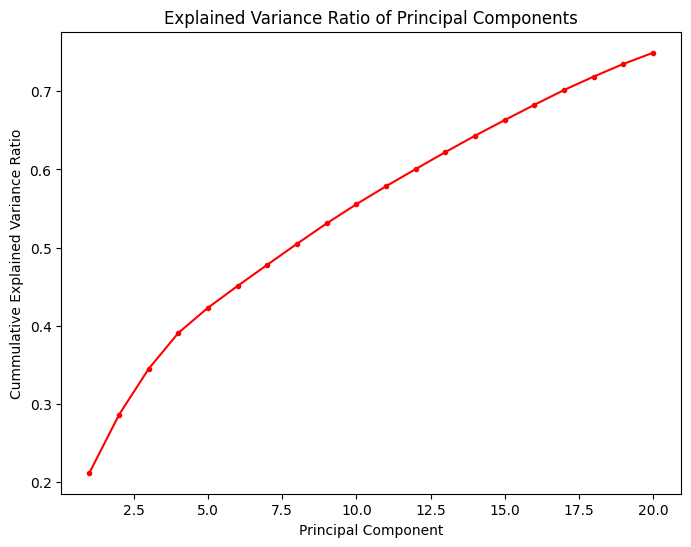

In [90]:
# Calculate the explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_var_ratio) + 1), np.cumsum(explained_var_ratio),marker='.', color='r', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Cummulative Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

We can see that the we need many components to explain 75% of the variance

In [107]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  14.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  15.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  15.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  31.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  30.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  31.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  13.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  13.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 1.0min
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  13.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 1.0min
[CV] END max_depth=None, min_sam

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [108]:
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


In [92]:
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
random_forest.fit(X_train_pca, y_train)


RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42)

In [93]:
y_pred_train = random_forest.predict(X_train_pca)
y_pred_test = random_forest.predict(pca.transform(scaler.transform(X_test)))

y_pred_train = y_pred_train * std_duration_train
y_pred_test = y_pred_test * std_duration_test
y_train_ = y_train * std_duration_train
y_test_ = y_test * std_duration_test

print("########### TEST ###########")
print("R-squared :", r2_score(y_test_,y_pred_test))
print("MSE :", mean_squared_error(y_test_,y_pred_test))
print("MAE :", mean_absolute_error(y_test_,y_pred_test))

print("########### TRAIN ###########")
print("R-squared :", r2_score(y_train_,y_pred_train))
print("MSE :", mean_squared_error(y_train_,y_pred_train))
print("MAE :", mean_absolute_error(y_train_,y_pred_train))

########### TEST ###########
R-squared : 0.1728598645868995
MSE : 295.2050080341963
MAE : 9.66870410403493
########### TRAIN ###########
R-squared : 0.5931201594402775
MSE : 87.61729904119646
MAE : 6.532206399075386


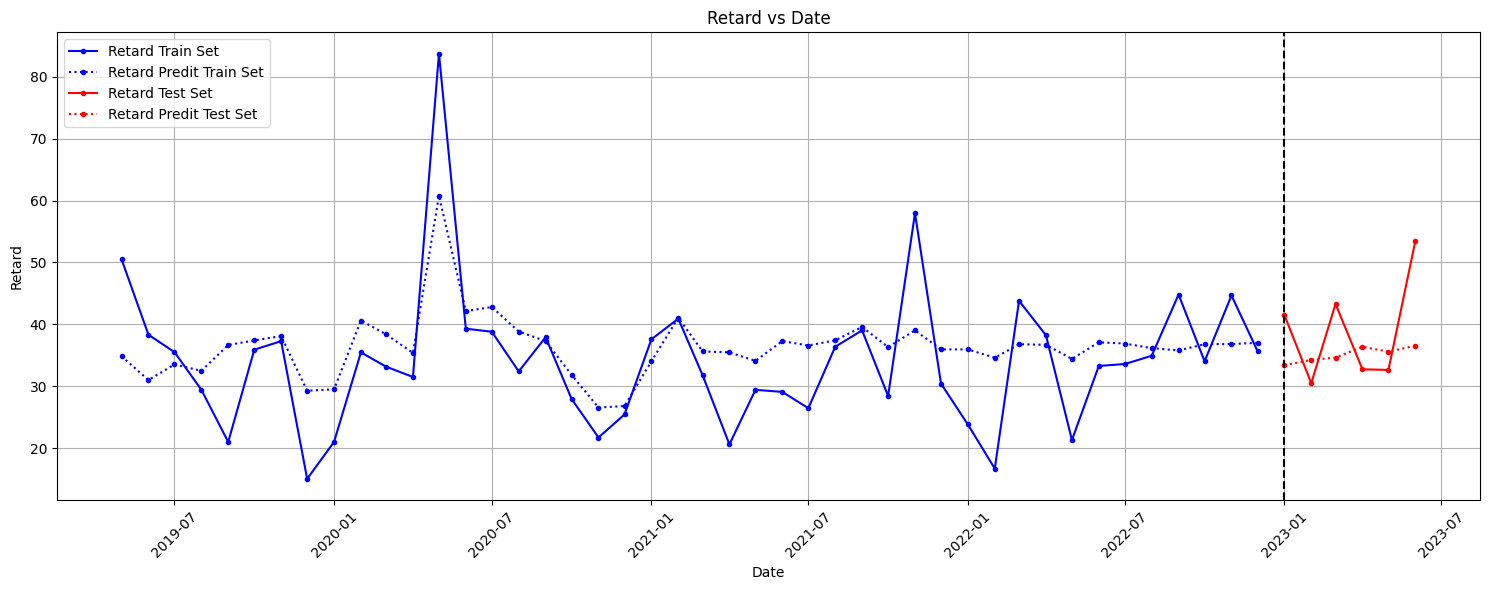

In [94]:
visualize_itinerary("GRENOBLE","PARIS LYON",train_df,test_df,y_train_,y_pred_train,y_test_,y_pred_test)

The performance of RandomForestRegressor is slightly better than LinearRegression but not as better as expected. Maybe this could be linked to the fact we used PCA and we are losing information. We are not able to run the grid search for the whole number of features, but we can test to train a Random Forest using the same parameters

In [96]:
train_df,test_df,X_train,X_test,y_train,y_test,std_duration_train,std_duration_test = split_data(data_tgv,features_list,"retard_moyen_arrivee_norm")

In [97]:
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42)

########### TEST ###########
R-squared : 0.14352648884154218
MSE : 305.67404351178624
MAE : 9.720790383088687
########### TRAIN ###########
R-squared : 0.6924096194352249
MSE : 66.23635695262105
MAE : 5.738070779459452


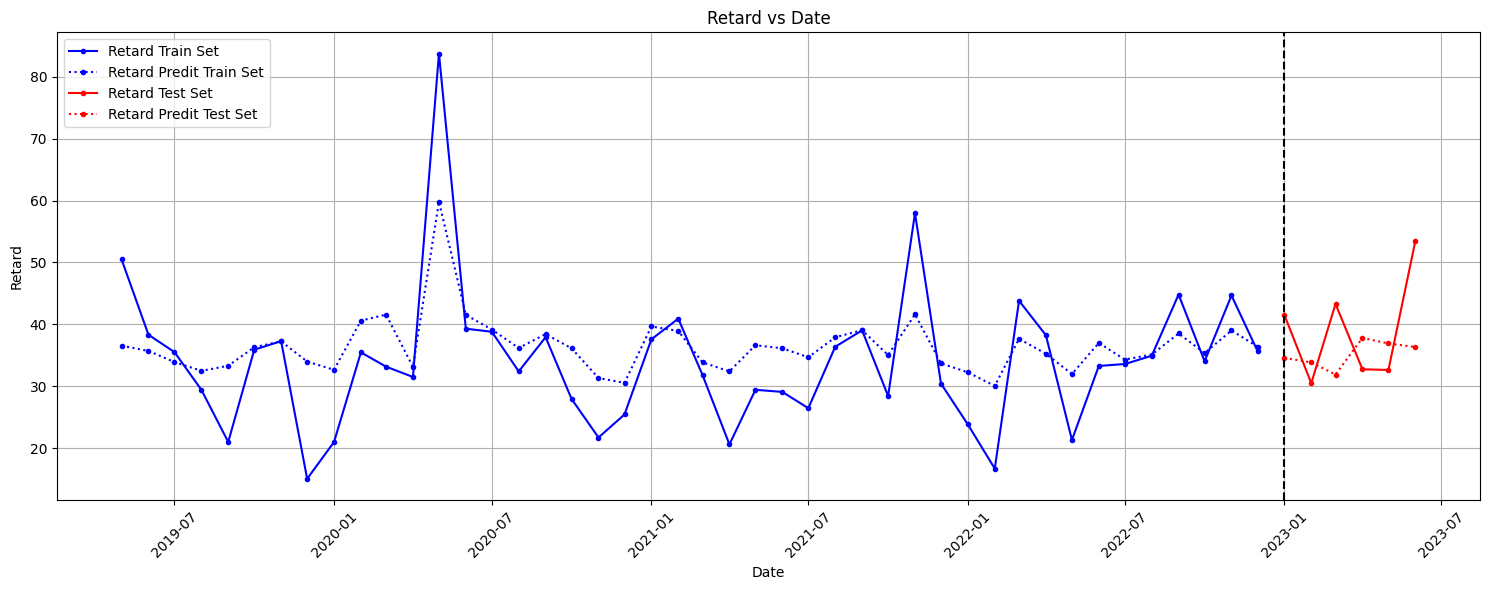

In [99]:
y_pred_train = random_forest.predict(X_train)
y_pred_test = random_forest.predict(X_test)

y_pred_train = y_pred_train * std_duration_train
y_pred_test = y_pred_test * std_duration_test
y_train_ = y_train * std_duration_train
y_test_ = y_test * std_duration_test

print("########### TEST ###########")
print("R-squared :", r2_score(y_test_,y_pred_test))
print("MSE :", mean_squared_error(y_test_,y_pred_test))
print("MAE :", mean_absolute_error(y_test_,y_pred_test))

print("########### TRAIN ###########")
print("R-squared :", r2_score(y_train_,y_pred_train))
print("MSE :", mean_squared_error(y_train_,y_pred_train))
print("MAE :", mean_absolute_error(y_train_,y_pred_train))

visualize_itinerary("GRENOBLE","PARIS LYON",train_df,test_df,y_train_,y_pred_train,y_test_,y_pred_test)

Without the pca, RandomForest performance is worst.

### GradientBoostingRegressor

For GradientBoostingRegressor we are on the same situation, we need to reduce the dimension to be able to do a grid search for hyperparameters tuning

In [117]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [50, 100, 150],              # Number of boosting stages to be run
    'learning_rate': [0.05, 0.1, 0.2],            # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 4, 5],                       # Maximum depth of the individual estimators
    'min_samples_split': [2, 3, 4],               # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3],                # Minimum number of samples required to be at a leaf node
    'subsample': [0.8, 0.9, 1.0]                  # Fraction of samples used for fitting the individual base learners
}

gb = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   3.5s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   3.5s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   3.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.9; total time=   4.4s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.9; total time=   5.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.9; total time=   5.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   5.5s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, 

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 0.9, 1.0]},
             verbose=2)

In [118]:
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}


########### TEST ###########
R-squared : 0.16697812979993043
MSE : 297.30418989069636
MAE : 9.586830945309838
########### TRAIN ###########
R-squared : 0.4766167443989935
MSE : 112.70508550156916
MAE : 7.193611337616154


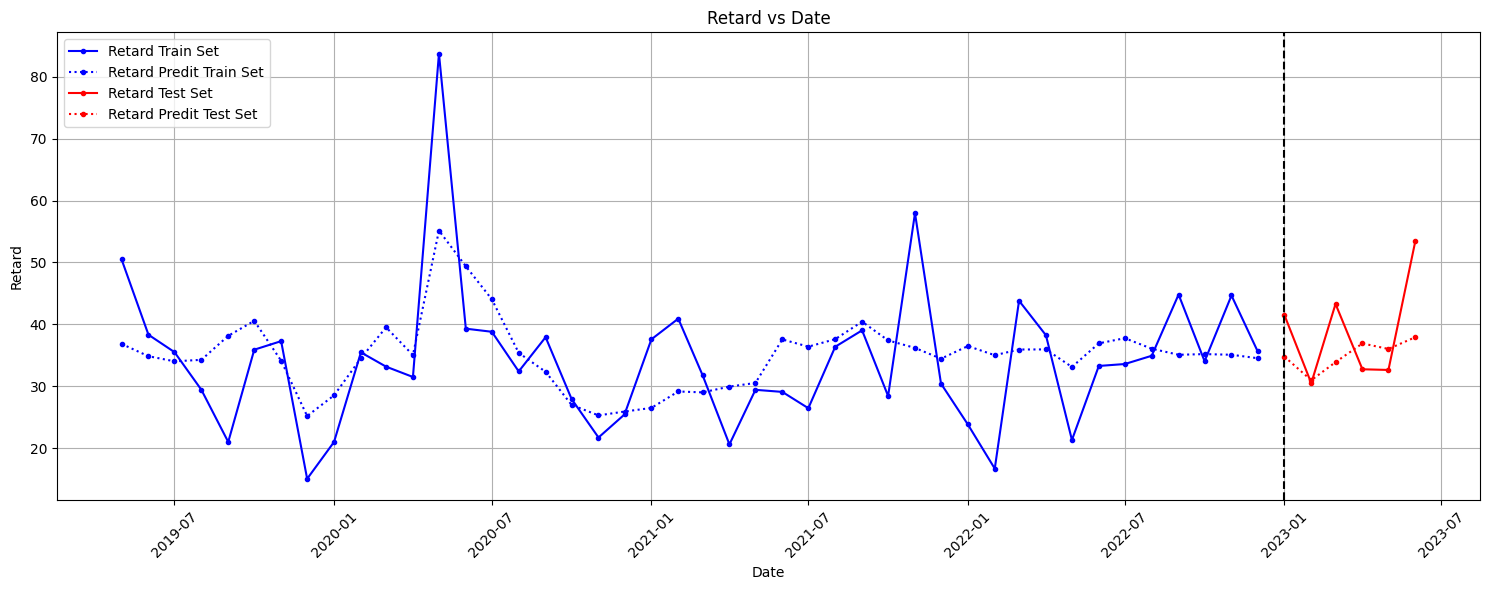

In [100]:
g_boost = GradientBoostingRegressor(learning_rate= 0.05, max_depth= 4, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 150, subsample= 0.8, random_state=42)
g_boost.fit(X_train_pca, y_train)

y_pred_train = g_boost.predict(X_train_pca)
y_pred_test = g_boost.predict(pca.transform(scaler.transform(X_test)))

y_pred_train = y_pred_train * std_duration_train
y_pred_test = y_pred_test * std_duration_test
y_train_ = y_train * std_duration_train
y_test_ = y_test * std_duration_test

print("########### TEST ###########")
print("R-squared :", r2_score(y_test_,y_pred_test))
print("MSE :", mean_squared_error(y_test_,y_pred_test))
print("MAE :", mean_absolute_error(y_test_,y_pred_test))

print("########### TRAIN ###########")
print("R-squared :", r2_score(y_train_,y_pred_train))
print("MSE :", mean_squared_error(y_train_,y_pred_train))
print("MAE :", mean_absolute_error(y_train_,y_pred_train))

visualize_itinerary("GRENOBLE","PARIS LYON",train_df,test_df,y_train_,y_pred_train,y_test_,y_pred_test)


########### TEST ###########
R-squared : 0.16265712344164707
MSE : 298.84635023584246
MAE : 9.489605787177886
########### TRAIN ###########
R-squared : 0.5240283731566331
MSE : 102.4954893486269
MAE : 6.8032565689855815


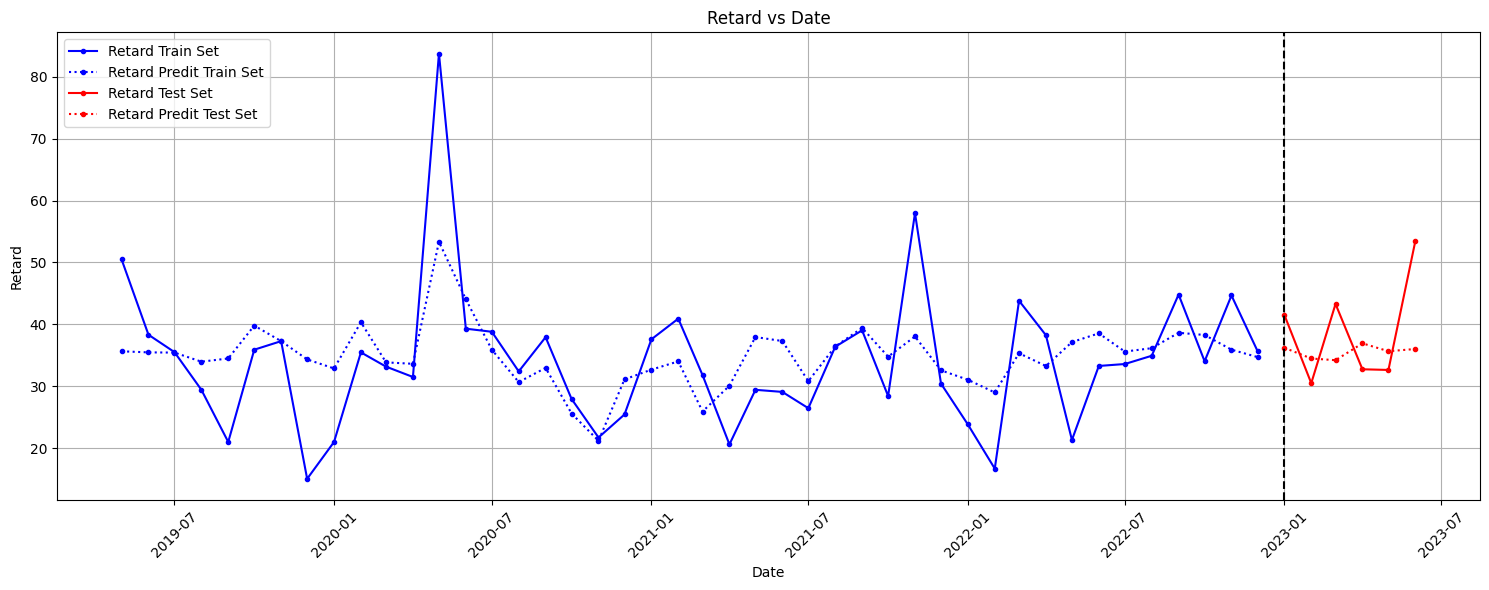

In [101]:
g_boost = GradientBoostingRegressor(learning_rate= 0.05, max_depth= 4, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 150, subsample= 0.8, random_state=42)
g_boost.fit(X_train, y_train)

y_pred_train = g_boost.predict(X_train)
y_pred_test = g_boost.predict(X_test)

y_pred_train = y_pred_train * std_duration_train
y_pred_test = y_pred_test * std_duration_test
y_train_ = y_train * std_duration_train
y_test_ = y_test * std_duration_test

print("########### TEST ###########")
print("R-squared :", r2_score(y_test_,y_pred_test))
print("MSE :", mean_squared_error(y_test_,y_pred_test))
print("MAE :", mean_absolute_error(y_test_,y_pred_test))

print("########### TRAIN ###########")
print("R-squared :", r2_score(y_train_,y_pred_train))
print("MSE :", mean_squared_error(y_train_,y_pred_train))
print("MAE :", mean_absolute_error(y_train_,y_pred_train))

visualize_itinerary("GRENOBLE","PARIS LYON",train_df,test_df,y_train_,y_pred_train,y_test_,y_pred_test)